In [2]:
import os
import argparse
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [3]:
from PlotSpinalCordDatafile import test as sodiumInterpVals
from PlotSpinalCordDatafile import interpTimes, times

BUN , BUN/Creatinine Ratio
0.8774417368026577
BUN/Creatinine Ratio , BUN
0.8774417368026577


In [21]:
parser = argparse.ArgumentParser('ODE demo')
parser.add_argument('--method', type=str, choices=['dopri5', 'adams'], default='dopri5')
parser.add_argument('--data_size', type=int, default=1521)
parser.add_argument('--batch_time', type=int, default=2)
parser.add_argument('--batch_size', type=int, default=2)
parser.add_argument('--niters', type=int, default=1000)
parser.add_argument('--test_freq', type=int, default=20)
parser.add_argument('--viz', default=True, action='store_false')
parser.add_argument('--gpu', type=int, default=0)
parser.add_argument('--adjoint', action='store_true')
# line below is edited to fix error
args, unknown = parser.parse_known_args()

In [22]:
if args.adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

In [23]:
device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')
#device = 'cpu'

In [24]:
print(device)

cuda:0


In [38]:
true_y = torch.tensor((np.asarray(sodiumInterpVals[0])).astype('float32')).to(device)
true_y = true_y.reshape((1691,1))
t = (torch.linspace(0, times[0], int(times[0]/720))/24/60).to(device)

best_loss = 1000000000

In [26]:
true_y_train, true_y_test = train_test_split(true_y, test_size=0.1, shuffle=False)

In [27]:
rngGen = np.random.default_rng(2225)

def get_batch():
    size = args.data_size - args.batch_time
    rng = rngGen.integers(0,size-args.batch_time, endpoint=True) # Gen random num from 0 - 1659
    
    # 1d tensor with batch_size number of entries containing consecutive ints
    s = torch.from_numpy(np.arange(size, dtype=np.int64)[rng : rng + args.batch_size])
    
    # initial points to perform ODESolver on
    batch_y0 = true_y_train[s]
    
    # Times to generate points for. Contains the next batch_time number of times following those corresponding to batch_y0's
    batch_t = t[(s)[:args.batch_time]]  # (T)
    
    # Values for batch_t times to test against and generate loss
    batch_y = torch.stack([true_y[s + i] for i in range(args.batch_time)], dim=0)  # (T, M, D)
    
    return batch_y0.to(device), batch_t.to(device), batch_y.to(device)

In [28]:
def makedirs(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)

In [29]:
# if args.viz:
#     makedirs('png')
#     import matplotlib.pyplot as plt
#     fig = plt.figure(figsize=(12, 4), facecolor='white')
#     ax_traj = fig.add_subplot(131, frameon=False)
#     ax_phase = fig.add_subplot(132, frameon=False)
#     ax_vecfield = fig.add_subplot(133, frameon=False)
#     plt.show(block=False)

In [30]:
# def visualize(true_y, pred_y, odefunc, itr):

#     if args.viz:

#         ax_traj.cla()
#         ax_traj.set_title('Trajectories')
#         ax_traj.set_xlabel('t')
#         ax_traj.set_ylabel('x,y')
#         ax_traj.plot(t.cpu().numpy(), true_y.cpu().numpy()[:, 0, 0], t.cpu().numpy(), true_y.cpu().numpy()[:, 0, 1], 'g-')
#         ax_traj.plot(t.cpu().numpy(), pred_y.cpu().numpy()[:, 0, 0], '--', t.cpu().numpy(), pred_y.cpu().numpy()[:, 0, 1], 'b--')
#         ax_traj.set_xlim(t.cpu().min(), t.cpu().max())
#         ax_traj.set_ylim(-2, 2)
#         ax_traj.legend()

#         ax_phase.cla()
#         ax_phase.set_title('Phase Portrait')
#         ax_phase.set_xlabel('x')
#         ax_phase.set_ylabel('y')
#         ax_phase.plot(true_y.cpu().numpy()[:, 0, 0], true_y.cpu().numpy()[:, 0, 1], 'g-')
#         ax_phase.plot(pred_y.cpu().numpy()[:, 0, 0], pred_y.cpu().numpy()[:, 0, 1], 'b--')
#         ax_phase.set_xlim(-2, 2)
#         ax_phase.set_ylim(-2, 2)

#         ax_vecfield.cla()
#         ax_vecfield.set_title('Learned Vector Field')
#         ax_vecfield.set_xlabel('x')
#         ax_vecfield.set_ylabel('y')

#         y, x = np.mgrid[-2:2:21j, -2:2:21j]
#         dydt = odefunc(0, torch.Tensor(np.stack([x, y], -1).reshape(21 * 21, 2)).to(device)).cpu().detach().numpy()
#         mag = np.sqrt(dydt[:, 0]**2 + dydt[:, 1]**2).reshape(-1, 1)
#         dydt = (dydt / mag)
#         dydt = dydt.reshape(21, 21, 2)

#         ax_vecfield.streamplot(x, y, dydt[:, :, 0], dydt[:, :, 1], color="black")
#         ax_vecfield.set_xlim(-2, 2)
#         ax_vecfield.set_ylim(-2, 2)

#         fig.tight_layout()
#         plt.savefig('png/{:03d}'.format(itr))
#         plt.draw()
#         plt.pause(0.001)

In [31]:
class ODEFunc(nn.Module):

    def __init__(self):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            #add more layers rather than more nodes
            nn.Linear(1, 100),
            nn.Tanh(),
            nn.Linear(100,90),
            nn.Tanh(),
            nn.Linear(90,80),
            nn.Tanh(),
            nn.Linear(80, 70),
            nn.Tanh(),
            nn.Linear(70,60),
            nn.Tanh(),
            nn.Linear(60,50),
            nn.Tanh(),
            nn.Linear(50,40),
            nn.Tanh(),
            nn.Linear(40,30),
            nn.Tanh(),
            nn.Linear(30,20),
            nn.Tanh(),
            nn.Linear(20,10),
            nn.Tanh(),
            nn.Linear(10,1),
            nn.Tanh(),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)

In [32]:
# class RunningAverageMeter(object):
#     """Computes and stores the average and current value"""

#     def __init__(self, momentum=0.99):
#         self.momentum = momentum
#         self.reset()

#     def reset(self):
#         self.val = None
#         self.avg = 0

#     def update(self, val):
#         if self.val is None:
#             self.avg = val
#         else:
#             self.avg = self.avg * self.momentum + val * (1 - self.momentum)
#         self.val = val


In [33]:
ii = 0

func = ODEFunc().to(device)

optimizer = optim.Adam(func.parameters(), lr=1e-4)
end = time.time()

# time_meter = RunningAverageMeter(0.97)

# loss_meter = RunningAverageMeter(0.97)

temp_loss = 10000000

for itr in range(1, args.niters + 1):
        optimizer.zero_grad()
        batch_y0, batch_t, batch_y = get_batch()
        pred_y = odeint(func, batch_y0, batch_t, method='dopri5').to(device)
        loss = torch.mean(torch.square(pred_y - batch_y))
        loss.backward()
        optimizer.step()

#         time_meter.update(time.time() - end)
#         loss_meter.update(loss.item())

        if itr % args.test_freq == 0:
            with torch.no_grad():
                pred_y = odeint(func, true_y_train, t[:1521], method='dopri5')
                loss = torch.mean(torch.square(pred_y - true_y_train))
                print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
#                 visualize(true_y, pred_y, func, ii)
#                 ii += 1
                if temp_loss > loss.item():
                    temp_loss = loss.item()
                    temp_pred = torch.clone(pred_y)
        end = time.time()

Iter 0020 | Total Loss 1.332924
Iter 0040 | Total Loss 4.535427
Iter 0060 | Total Loss 0.214562
Iter 0080 | Total Loss 41.113239
Iter 0100 | Total Loss 13.093819
Iter 0120 | Total Loss 3.247360
Iter 0140 | Total Loss 8.477054
Iter 0160 | Total Loss 3.782810
Iter 0180 | Total Loss 0.247966
Iter 0200 | Total Loss 0.855570
Iter 0220 | Total Loss 4.680179
Iter 0240 | Total Loss 6.427912
Iter 0260 | Total Loss 9.971390
Iter 0280 | Total Loss 4.572869
Iter 0300 | Total Loss 0.558810
Iter 0320 | Total Loss 1.542726
Iter 0340 | Total Loss 9.175077
Iter 0360 | Total Loss 8.507881
Iter 0380 | Total Loss 14.749225
Iter 0400 | Total Loss 32.335369
Iter 0420 | Total Loss 24.842993
Iter 0440 | Total Loss 26.191628
Iter 0460 | Total Loss 17.026451
Iter 0480 | Total Loss 4.276896
Iter 0500 | Total Loss 4.144743
Iter 0520 | Total Loss 3.349540
Iter 0540 | Total Loss 3.654124
Iter 0560 | Total Loss 8.195995
Iter 0580 | Total Loss 8.566195
Iter 0600 | Total Loss 9.795826
Iter 0620 | Total Loss 8.012410
I

0.21456198394298553
tensor([[[143.0000],
         [143.5161],
         [144.0321],
         ...,
         [140.3854],
         [140.3890],
         [140.3926]],

        [[142.9995],
         [143.5155],
         [144.0316],
         ...,
         [140.3849],
         [140.3885],
         [140.3920]],

        [[142.9990],
         [143.5150],
         [144.0311],
         ...,
         [140.3843],
         [140.3879],
         [140.3915]],

        ...,

        [[142.2116],
         [142.7298],
         [143.2481],
         ...,
         [139.5855],
         [139.5890],
         [139.5926]],

        [[142.2110],
         [142.7293],
         [143.2476],
         ...,
         [139.5849],
         [139.5885],
         [139.5921]],

        [[142.2105],
         [142.7288],
         [143.2471],
         ...,
         [139.5844],
         [139.5880],
         [139.5916]]], device='cuda:0')


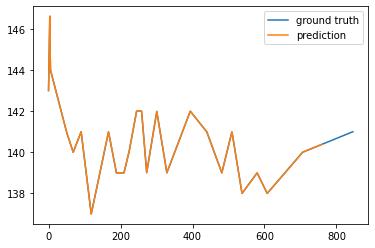

In [36]:
print(temp_loss)
print(temp_pred)
plt.plot(t.cpu(), true_y.cpu(), label='ground truth')
plt.plot(t[:1521].cpu(), temp_pred[0].cpu(), label='prediction')
plt.legend()

0.21456198394298553
tensor([[[143.0000],
         [143.5161],
         [144.0321],
         ...,
         [140.3854],
         [140.3890],
         [140.3926]],

        [[142.9995],
         [143.5155],
         [144.0316],
         ...,
         [140.3849],
         [140.3885],
         [140.3920]],

        [[142.9990],
         [143.5150],
         [144.0311],
         ...,
         [140.3843],
         [140.3879],
         [140.3915]],

        ...,

        [[142.2116],
         [142.7298],
         [143.2481],
         ...,
         [139.5855],
         [139.5890],
         [139.5926]],

        [[142.2110],
         [142.7293],
         [143.2476],
         ...,
         [139.5849],
         [139.5885],
         [139.5921]],

        [[142.2105],
         [142.7288],
         [143.2471],
         ...,
         [139.5844],
         [139.5880],
         [139.5916]]], device='cuda:0')


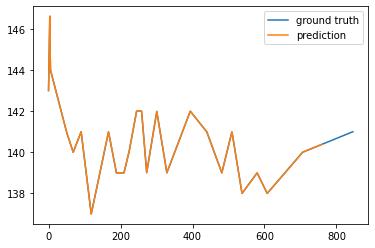

In [40]:
if temp_loss < best_loss:
    best_loss = temp_loss
    best_pred = torch.clone(temp_pred)
print(best_loss)
print(best_pred)
plt.plot(t.cpu(), true_y.cpu(), label='ground truth')
plt.plot(t[:1521].cpu(), best_pred[0].cpu(), label='prediction')
plt.legend()